# Learning Uncertainty Sets

In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import sys
import ot
sys.path.append('..')
from utils import plot_tradeoff,plot_iters
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "blue", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "red"]

### Example 3: Affine Adjustable Robust Optimization: Inventory management

We solve the robust optimization problem given as 
\begin{equation*}
	\begin{array}{ll}
		\text{minimize} & L\\
		\text{subject to} & -r^Ty^0 - r^TYu + (t+h)^Ts \le L, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
		& y^0_i + y_i^Tu\leq s_i, \quad i = 1, \dots, N, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
		& y^0_i + y_i^Tu \leq d_i^0 + q_i^Tu, \quad i = 1, \dots, N, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
			& \mathbf{1}^Ts = C\\
			& s \leq c\\
			& s \geq 0.
	\end{array}
\end{equation*}


In [2]:
def data_scaled(N, m, scale, seed):
    np.random.seed(seed)
    R = np.vstack([np.random.normal(
        i*0.03*scale, np.sqrt((0.02**2+(i*0.1)**2)), N) for i in range(1, m+1)])
    return (R.transpose())

def data_modes(N, m, scales, seed):
    modes = len(scales)
    d = np.zeros((N+100, m))
    weights = int(np.ceil(N/modes))
    for i in range(modes):
        d[i*weights:(i+1)*weights,
          :] = data_scaled(weights, m, scales[i], seed)
    return d[0:N, :]

def loss(L,y,Y,s,r,alpha, data,l=10000,quantile = 0.95, target = -0.1):
    sums = 0
    totsum = torch.tensor(0.)
    objs = 0
    if len(torch.tensor(data).shape) <2:
        Nsample = 1
        data = [data]
    else:
        Nsample = data.shape[0]
    for i in range(Nsample):
        sums += torch.sum(torch.maximum(y + Y@data[i] - s-alpha, torch.tensor(0.,requires_grad = True)))
        sums += torch.sum(torch.maximum(y + Y@data[i] - torch.tensor(d) - torch.tensor(Q)@data[i] - alpha, torch.tensor(0.,requires_grad = True)))
        sums += torch.maximum(-r@y - r@Y@data[i] + torch.tensor(t+ h)@s - L - alpha, torch.tensor(0.,requires_grad = True))

        objs += -r@y - r@Y@data[i] + torch.tensor(t+ h)@s
        
        newsums = torch.sum(torch.where(torch.maximum(y + Y@data[i] - s, torch.tensor(0.,requires_grad = True))>=0.0001,torch.tensor(1.), torch.tensor(0.)))
        newsums += torch.sum(torch.where(torch.maximum(y + Y@data[i] - torch.tensor(d) - torch.tensor(Q)@data[i], torch.tensor(0.,requires_grad = True))>=0.0001,torch.tensor(1.), torch.tensor(0.)))
        newsums += torch.where(torch.maximum(-r@y - r@Y@data[i] + torch.tensor(t+ h)@s - L, torch.tensor(0.,requires_grad = True))>=0.0001, torch.tensor(1.), torch.tensor(0.))
        if newsums >=1:
            totsum += torch.tensor(1.)
    sums = (sums/((1-quantile)*Nsample)) + alpha
    return L + torch.tensor(l)*(sums - torch.tensor(target)), objs/Nsample, totsum/Nsample, sums.detach().numpy()


n = 10
m = 4

r = np.random.uniform(20,40,n)
scenarios = {}
num_scenarios = 5
for scene in range(num_scenarios):
    np.random.seed(scene)
    scenarios[scene] = {}
    scenarios[scene][0] = r + np.random.normal(0,0.5,n)

np.random.seed(27)
C = 2000
c = np.random.uniform(300,500,n)
Q = np.random.uniform(-2,2,(n,m))
d = np.random.uniform(100,200,n)
t = np.random.uniform(1,3,n)
h = np.random.uniform(1,3,n)

In [3]:
saved_s = np.load("scenarios.npy")
num_scenarios = 5
for scene in range(num_scenarios):
    scenarios[scene] = {}
    scenarios[scene][0] = saved_s[scene]

seed = 27
n = 10
m = 4
data = data_modes(600,m,[10,20,30],seed = seed)
# formulate the ellipsoidal set
u = lropt.UncertainParameter(m,
                                uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                  rho=1., data =data, loss =loss))
# formulate cvxpy variable
L = cp.Variable()
s = cp.Variable(n)
y = cp.Variable(n)
Y = cp.Variable((n,m))
r = cp.Parameter(n)

# formulate problem constants
np.random.seed(27)
C = 2000
c = np.random.uniform(300,500,n)
Q = np.random.uniform(-2,2,(n,m))
d = np.random.uniform(100,200,n)
t = np.random.uniform(1,3,n)
h = np.random.uniform(1,3,n)

# formulate objective
objective = cp.Minimize(L)

# formulate constraints
# constraints = [cp.maximum(-r@y - r@Y@u + (t+h)@s - L, y[0]+Y[0]@u -s[0],y[1]+Y[1]@u -s[1],y[2]+Y[2]@u -s[2],y[3]+Y[3]@u -s[3],y[4]+Y[4]@u -s[4],y[5]+Y[5]@u -s[5],y[6]+Y[6]@u -s[6],y[7]+Y[7]@u -s[7], y[8]+Y[8]@u -s[8],y[9]+Y[9]@u -s[9],y[0] - d[0] - (Q[0] - Y[0])@u,y[1] - d[1] - (Q[1] - Y[1])@u,y[2] - d[2] - (Q[2] - Y[2])@u ,y[3] - d[3] - (Q[3] - Y[3])@u,y[4] - d[4] - (Q[4] - Y[4])@u,y[5] - d[5] - (Q[5] - Y[5])@u,y[6] - d[6] - (Q[6] - Y[6])@u,y[7] - d[7] - (Q[7] - Y[7])@u,y[8] - d[8] - (Q[8] - Y[8])@u,y[9] - d[9] - (Q[9] - Y[9])@u ) <= 0]
constraints = [-r@y - r@Y@u + (t+h)@s <= L]
for i in range(n):
    constraints += [y[i]+Y[i]@u <= s[i]]
    constraints += [y[i]<= d[i]+ (Q[i] - Y[i])@u]
constraints += [np.ones(n)@s == C]
constraints += [s <=c, s >=0]

# formulate Robust Problem
prob = lropt.RobustProblem(objective, constraints)
target = -0.05
# solve
test_p = 0.5

In [4]:
seed = 27
n = 10
m = 4
data = data_modes(600,m,[10,20,30],seed = 45)
# formulate the ellipsoidal set
u = lropt.UncertainParameter(m,
                                uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                  rho=1., data =data, loss =loss))
# formulate cvxpy variable
L = cp.Variable()
s = cp.Variable(n)
y = cp.Variable(n)
Y = cp.Variable((n,m))
r = cp.Parameter(n)

# formulate problem constants
np.random.seed(27)
C = 2000
c = np.random.uniform(300,500,n)
Q = np.random.uniform(-2,2,(n,m))
d = np.random.uniform(100,200,n)
t = np.random.uniform(1,3,n)
h = np.random.uniform(1,3,n)

# formulate objective
objective = cp.Minimize(L)

# formulate constraints
# constraints = [cp.maximum(-r@y - r@Y@u + (t+h)@s - L, y[0]+Y[0]@u -s[0],y[1]+Y[1]@u -s[1],y[2]+Y[2]@u -s[2],y[3]+Y[3]@u -s[3],y[4]+Y[4]@u -s[4],y[5]+Y[5]@u -s[5],y[6]+Y[6]@u -s[6],y[7]+Y[7]@u -s[7], y[8]+Y[8]@u -s[8],y[9]+Y[9]@u -s[9],y[0] - d[0] - (Q[0] - Y[0])@u,y[1] - d[1] - (Q[1] - Y[1])@u,y[2] - d[2] - (Q[2] - Y[2])@u ,y[3] - d[3] - (Q[3] - Y[3])@u,y[4] - d[4] - (Q[4] - Y[4])@u,y[5] - d[5] - (Q[5] - Y[5])@u,y[6] - d[6] - (Q[6] - Y[6])@u,y[7] - d[7] - (Q[7] - Y[7])@u,y[8] - d[8] - (Q[8] - Y[8])@u,y[9] - d[9] - (Q[9] - Y[9])@u ) <= 0]
constraints = [-r@y - r@Y@u + (t+h)@s <= L]
for i in range(n):
    constraints += [y[i]+Y[i]@u <= s[i]]
    constraints += [y[i]<= d[i]+ (Q[i] - Y[i])@u]
constraints += [np.ones(n)@s == C]
constraints += [s <=c, s >=0]

# formulate Robust Problem
prob = lropt.RobustProblem(objective, constraints)
target = -0.05
# solve
test_p = 0.5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=seed)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
init_bval = -init@np.mean(train, axis=0)
result1 = prob.train(lr = 0.000005, step=300, momentum = 0.8, optimizer = "SGD", seed = seed, init_A = 0.3*init, init_b = 0.3*init_bval, fixb = False, init_lam = 0.1, target_cvar = target, init_alpha = -0.05, test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.005, batch_percentage= 0.6)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

# result3 = prob.train(eps = True, lr = 0.00001, step=500, momentum = 0.8, optimizer = "SGD", seed = seed, init_A = 0.3*init, init_b =0.3*init_bval,  init_lam = 5,target_cvar = target, init_alpha = -0.05, test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios,step_y = 0.1)
# df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 1.5, 40), init_A = 0.3*init, init_b = 0.3*init_bval, seed = seed, init_alpha = 0., test_percentage =test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid = result4.df

result5 = prob.grid(epslst = np.linspace(0.01,1.5, 40), init_A = A_fin, init_b = b_fin, seed = seed, init_alpha = 0., test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid2 = result5.df

In [5]:
def plot_coverage_all(df_standard,df_reshape,dfs,title,ind_1 = (0,100), ind_2 = (0,100), logscale = True):
    plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
    beg1,end1 = ind_1
    beg2,end2 = ind_2

    fig, (ax, ax1,ax2) = plt.subplots(1, 3, figsize=(23, 3))
    
    ax.plot(np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")
    ax.fill(np.append(np.quantile(np.vstack(df_standard['Violations']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Violations']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.9,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax.plot(np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set")
    ax.fill(np.append(np.quantile(np.vstack(df_reshape['Violations']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Violations']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.9,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    ax.set_xlabel("Probability of constraint violation")
    ax.axvline(x = 0.03, color = "green", linestyle = "-.",label = r"$\eta = 0.03$")
    ax.set_ylabel("Objective value")
    ax.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax.legend()

    ax1.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")
    ax1.fill(np.append(np.quantile(np.vstack(df_standard['coverage_test']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['coverage_test']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.90,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax1.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",label=r"Decision-Focused set")
    ax1.fill(np.append(np.quantile(np.vstack(df_reshape['coverage_test']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['coverage_test']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.90,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    if dfs:
        for i in range(5):
            ax1.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Test_val']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax1.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")

    ax1.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax1.axvline(x = 0.8, color = "black", linestyle = ":",label = "0.8 Coverage")

    if logscale:
        ax1.set_xscale("log")
    ax1.set_xlabel("Test set coverage")
    ax1.set_ylabel("Objective value")
    # ax1.legend()

    ax2.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")

    ax2.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set",alpha = 0.8)
    if dfs:
        for i in range(5):
            ax2.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Violations']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax2.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Violations']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")
    # ax2.plot(np.arange(100)/100, 1 - np.arange(100)/100, color = "red")
    # ax2.set_ylim([-0.05,0.25])
    ax2.axvline(x = 0.8, color = "black",linestyle = ":", label = "0.8 Coverage")
    ax2.axhline(y = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
    ax2.set_ylabel("Prob. of cons. vio.")
    ax2.set_xlabel("Test set coverage")
    if logscale:
        ax2.set_xscale("log")
    # ax2.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax2.legend()
    # lines_labels = [ax.get_legend_handles_labels()]
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels,loc='upper center', ncol=2,bbox_to_anchor=(0.5, 1.2))
    plt.savefig(title+"_curves.pdf",bbox_inches='tight')
    plt.show()

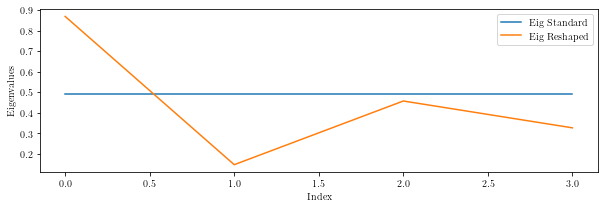

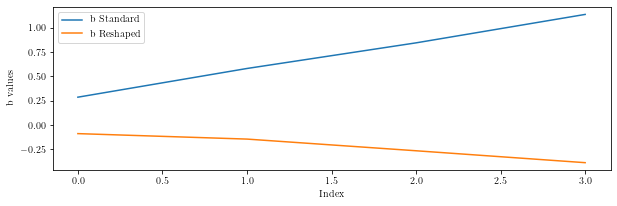

In [6]:
prob_list = np.array([0.,0.01,0.05,0.1])
inds_standard = []
inds_reshaped = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Violations']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Violations']),axis = 1)-i).argmin())
st_eps = np.linspace(0.5,3, 40)[inds_standard[0]]
re_eps = np.linspace(0.5,3, 40)[inds_reshaped[0]]
st_eps, re_eps
plt.figure(figsize=(10, 3))
plt.plot(np.linalg.eig((1/st_eps)*np.eye(m))[0],label = "Eig Standard")
plt.plot(np.linalg.eig((1/re_eps)*A_fin)[0],label = "Eig Reshaped")
plt.xlabel("Index")
plt.ylabel("Eigenvalues")
plt.legend()
plt.show()
plt.figure(figsize=(10, 3))
plt.plot((1/st_eps)*np.mean(train,axis = 0),label = "b Standard")
plt.plot((1/re_eps)*b_fin,label = "b Reshaped")
plt.xlabel("Index")
plt.ylabel("b values")
plt.legend()
plt.show()

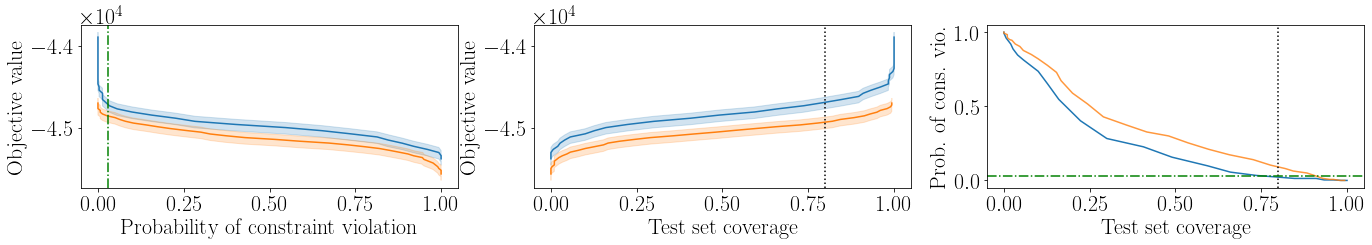

In [7]:
plot_coverage_all(dfgrid,dfgrid2,None, "inventory_4",ind_1=(0,100),ind_2=(0,100), logscale = False)

In [8]:
dfgrid.to_pickle("dfst_4.pkl")
dfgrid2.to_pickle("dfre_4.pkl")

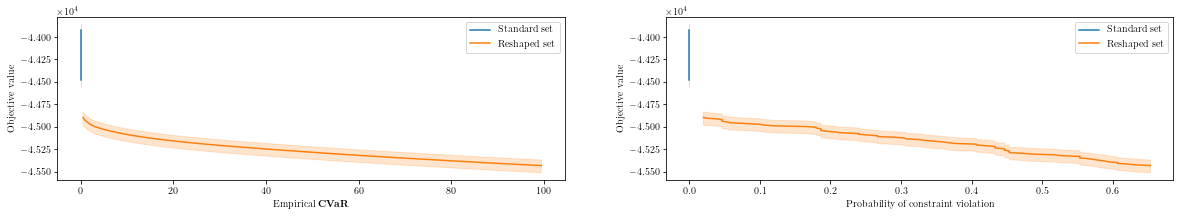

In [21]:
plot_tradeoff(dfgrid,dfgrid2,"inventory",ind_1 = (10,100), ind_2 = (16,100))

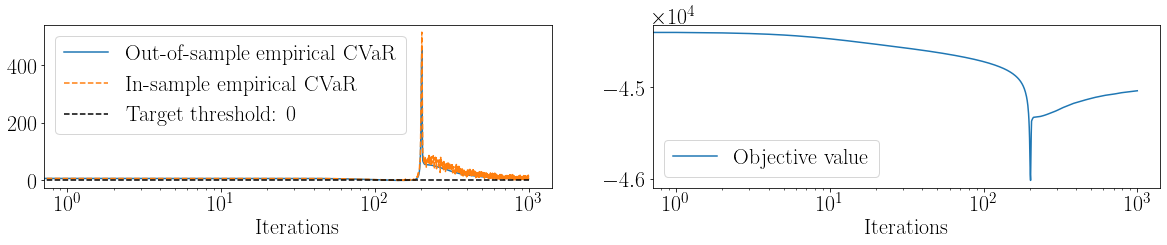

In [8]:
plot_iters(df1,"inventory_log", logscale = True, steps = 1000)

In [38]:
prob_list = np.array([0.,0.01,0.05,0.1])
inds_standard = []
inds_reshaped = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Violations']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Violations']),axis = 1)-i).argmin())
st_eps = np.linspace(0.01, 1.5, 40)[inds_standard[0]]
re_eps = np.linspace(0.01, 1.5, 40)[inds_reshaped[0]]
st_eps, re_eps

(0.8505128205128205, 1.308974358974359)

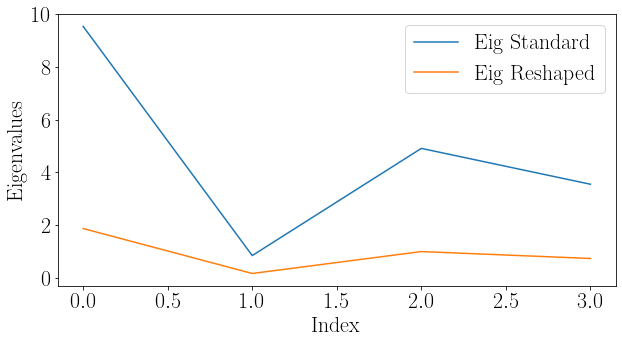

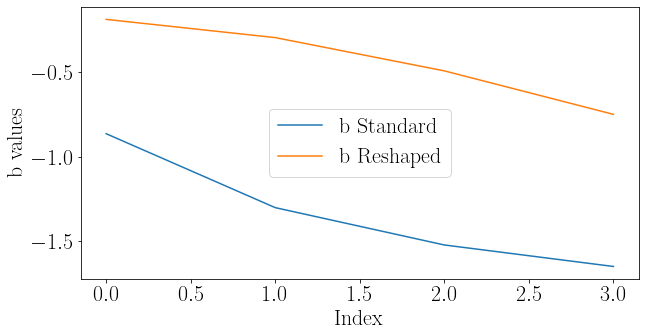

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(np.linalg.eig((1/st_eps)*init)[0],label = "Eig Standard")
plt.plot(np.linalg.eig((1/re_eps)*A_fin)[0],label = "Eig Reshaped")
plt.xlabel("Index")
plt.ylabel("Eigenvalues")
plt.legend()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot((1/st_eps)*init_bval,label = "b Standard")
plt.plot((1/re_eps)*b_fin,label = "b Reshaped")
plt.xlabel("Index")
plt.ylabel("b values")
plt.legend()
plt.show()

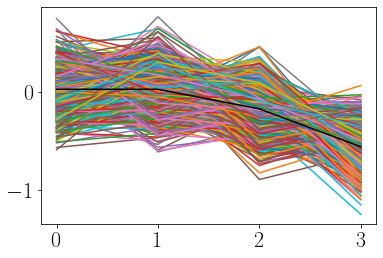

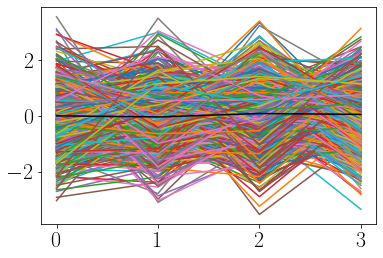

In [49]:
val = 0
for i in range(data.shape[0]):
  plt.plot((1/re_eps)*A_fin@data[i] + (1/re_eps)*b_fin)
  val += (1/re_eps)*A_fin@data[i] + (1/re_eps)*b_fin
plt.plot(val/data.shape[0],color = "black")
plt.show()
val = 0
for i in range(data.shape[0]):
  plt.plot((1/st_eps)*init@data[i] + (1/st_eps)*init_bval)
  val += (1/st_eps)*init@data[i] + (1/st_eps)*init_bval
plt.plot(val/data.shape[0],color = "black")
plt.show()

In [4]:
def eval(L,y,Y,s,r,data):
    L = torch.tensor(L)
    y = torch.tensor(y)
    Y = torch.tensor(Y)
    s = torch.tensor(s)
    r = torch.tensor(r)
    data = torch.tensor(data)
    totsum = torch.tensor(0.)
    Nsample = data.shape[0]
    for i in range(Nsample):
        newsums = torch.sum(torch.where(torch.maximum(y + Y@data[i] - s, torch.tensor(0.,requires_grad = True))>=0.0001,torch.tensor(1.), torch.tensor(0.)))
        newsums += torch.sum(torch.where(torch.maximum(y + Y@data[i] - torch.tensor(d) - torch.tensor(Q)@data[i], torch.tensor(0.,requires_grad = True))>=0.0001,torch.tensor(1.), torch.tensor(0.)))
        newsums += torch.where(torch.maximum(-r@y - r@Y@data[i] + torch.tensor(t+ h)@s - L, torch.tensor(0.,requires_grad = True))>=0.0001, torch.tensor(1.), torch.tensor(0.))
        if newsums >=1:
            totsum += torch.tensor(1.)
    return totsum/Nsample

In [5]:
def make_table(result_A, result_b, df,test,train,value = 0., eps = 1, cvar_train = 0, cvar_test=0):
    trial1 = np.zeros((num_scenarios,7))
    for scene in range(num_scenarios):
        # formulate the ellipsoidal set
        if eps:
            r_eps = 1
        else:
            r_eps = df['Eps'][np.absolute(np.mean(np.vstack(df['Violations_train']),axis = 1)-value).argmin()]
        u = lropt.UncertainParameter(m,
                                        uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                        rho=1., A = (1/r_eps)*result_A, b=(1/r_eps)*result_b))
        # formulate cvxpy variable
        L = cp.Variable()
        s = cp.Variable(n)
        y = cp.Variable(n)
        Y = cp.Variable((n,m))
        r = cp.Parameter(n)
        r.value = scenarios[scene][0]

        # formulate objective
        objective = cp.Minimize(L)

        # formulate constraints
        constraints = [-r@y - r@Y@u + (t+h)@s <= L]
        for i in range(n):
            constraints += [y[i]+Y[i]@u <= s[i]]
            constraints += [y[i]<= d[i]+ (Q[i] - Y[i])@u]
        constraints += [np.ones(n)@s == C]
        constraints += [s <=c, s >=0]

        # formulate Robust Problem
        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()
        coverage = 0
        for datind in range(test.shape[0]):
            coverage += np.where(np.linalg.norm((1/r_eps)*result_A@test[datind] + (1/r_eps)*result_b)<= 1, 1, 0 )
        coverage_train = 0
        for datind in range(train.shape[0]):
            coverage_train += np.where(np.linalg.norm((1/r_eps)*result_A@train[datind] + (1/r_eps)*result_b)<= 1, 1, 0 )

        trial1[scene,0] = newprob.objective.value
        trial1[scene,1] = eval(L.value,y.value,Y.value,s.value,r.value,test).item()
        trial1[scene,2] = eval(L.value,y.value,Y.value,s.value,r.value,train).item()
        trial1[scene,3] = coverage/test.shape[0]
        trial1[scene,4] = coverage_train/train.shape[0]
        trial1[scene,5] = newprob.solver_stats.solve_time
        trial1[scene,6] = np.linalg.det(sc.linalg.inv((1/r_eps)*result_A@((1/r_eps)*result_A)))**0.5
    return trial1

def sg(train, test):
    vios = np.zeros((num_scenarios))
    objs = np.zeros((num_scenarios))
    time = np.zeros((num_scenarios))
    for scene in range(num_scenarios):
        # formulate cvxpy variable
        L = cp.Variable()
        s = cp.Variable(n)
        y = cp.Variable(n)
        Y = cp.Variable((n,m))
        r = cp.Parameter(n)
        r.value = scenarios[scene][0]

        # formulate objective
        objective = cp.Minimize(L)
        constraints = []
        # formulate constraints
        for u in train:
            constraints += [-r@y - r@Y@u + (t+h)@s <= L]
            for i in range(n):
                constraints += [y[i]+Y[i]@u <= s[i]]
                constraints += [y[i]<= d[i]+ (Q[i] - Y[i])@u]
        constraints += [np.ones(n)@s == C]
        constraints += [np.ones(n)@s == C]
        constraints += [s <=c, s >=0]

        # formulate Robust Problem
        prob = cp.Problem(objective, constraints)
        prob.solve()
        objs[scene] = prob.objective.value
        vios[scene] = eval(L.value,y.value,Y.value,s.value,r.value,test).item()
        time[scene] = prob.solver_stats.solve_time
    return vios, objs, time

In [26]:
Ar_saved = np.zeros((100,m,m))
br_saved = np.zeros((100,m))
As_saved = np.zeros((100,m,m))
bs_saved = np.zeros((100,m))
reshaped_table = np.zeros((1,18))
standard_table = np.zeros((1,18))
for experiment in range(10):
    print(experiment)
    data = data_modes(300,m,[10,20,30],seed = experiment)
    # formulate the ellipsoidal set
    u = lropt.UncertainParameter(m,
                                    uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                    rho=1., data =data, loss =loss))
    # formulate cvxpy variable
    L = cp.Variable()
    s = cp.Variable(n)
    y = cp.Variable(n)
    Y = cp.Variable((n,m))
    r = cp.Parameter(n)
    r.value = scenarios[scene][0]

    # formulate objective
    objective = cp.Minimize(L)

    # formulate constraints
    # constraints = [cp.maximum(-r@y - r@Y@u + (t+h)@s - L, y[0]+Y[0]@u -s[0],y[1]+Y[1]@u -s[1],y[2]+Y[2]@u -s[2],y[3]+Y[3]@u -s[3],y[4]+Y[4]@u -s[4],y[5]+Y[5]@u -s[5],y[6]+Y[6]@u -s[6],y[7]+Y[7]@u -s[7], y[8]+Y[8]@u -s[8],y[9]+Y[9]@u -s[9],y[0] - d[0] - (Q[0] - Y[0])@u,y[1] - d[1] - (Q[1] - Y[1])@u,y[2] - d[2] - (Q[2] - Y[2])@u ,y[3] - d[3] - (Q[3] - Y[3])@u,y[4] - d[4] - (Q[4] - Y[4])@u,y[5] - d[5] - (Q[5] - Y[5])@u,y[6] - d[6] - (Q[6] - Y[6])@u,y[7] - d[7] - (Q[7] - Y[7])@u,y[8] - d[8] - (Q[8] - Y[8])@u,y[9] - d[9] - (Q[9] - Y[9])@u ) <= 0]
    constraints = [-r@y - r@Y@u + (t+h)@s <= L]
    for i in range(n):
        constraints += [y[i]+Y[i]@u <= s[i]]
        constraints += [y[i]<= d[i]+ (Q[i] - Y[i])@u]
    constraints += [np.ones(n)@s == C]
    constraints += [s <=c, s >=0]

    # formulate Robust Problem
    prob = lropt.RobustProblem(objective, constraints)
    target = -0.05
    # solve

    test_p = 0.5
    seed = 27
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=seed)
    init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
    init_bval = -init@np.mean(train, axis=0)
    result1 = prob.train(lr = 0.000001, step=1000, momentum = 0.8, optimizer = "SGD", seed = seed, init_A = 0.3*init, init_b = 0.3*init_bval, fixb = False, init_lam = 0.1, target_cvar = target, init_alpha = -0.05, test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.001)
    df1 = result1.df
    A_fin = result1.A
    b_fin = result1.b
    Ar_saved[experiment,:] = A_fin
    br_saved[experiment,:] = b_fin

    # result3 = prob.train(eps = True, lr = 0.000001, step=500, momentum = 0.8, optimizer = "SGD", seed = seed, init_A = 0.3*init, init_b =0.3*init_bval,  init_lam = 0, init_mu=1,target_cvar = target, init_alpha = -0.05, mu_multiplier = 1.013, test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    # df_r2 = result3.df
    # As_saved[experiment,:] = result3.A
    # bs_saved[experiment,:] = result3.b

    result4 = prob.grid(epslst = np.linspace(0.5, 1.6, 80), init_A = 0.3*init, init_b = 0.3*init_bval, seed = seed, init_alpha = 0., test_percentage =test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid = result4.df

    result5 = prob.grid(epslst = np.linspace(0.5,1.6, 80), init_A = A_fin, init_b = b_fin, seed = seed, init_alpha = 0., test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid2 = result5.df

    r_t = make_table(A_fin, b_fin, dfgrid2,test,train,0.045, eps = 0, cvar_train = df1["Violation_train"].values[-1], cvar_test = df1["Violation_val"].values[-1])
    r_t1 = make_table(A_fin, b_fin, dfgrid2,test,train,0.001, eps = 0,cvar_train = df1["Violation_train"].values[-1], cvar_test = df1["Violation_val"].values[-1])
    r_t2 = make_table(A_fin, b_fin, dfgrid2,test,train,0.03, eps = 0, cvar_train = df1["Violation_train"].values[-1], cvar_test = df1["Violation_val"].values[-1])
    r_t = np.hstack((r_t, r_t1,r_t2))
    reshaped_table = np.vstack((reshaped_table, r_t))

    s_t = make_table(0.3*init, 0.3*init_bval, dfgrid,test,train, 0.045, eps = 0,cvar_train = 0, cvar_test = 0)
    s_t1 = make_table(0.3*init, 0.3*init_bval, dfgrid,test,train, 0.001, eps = 0,cvar_train = 0, cvar_test = 0)
    s_t2 = make_table(0.3*init, 0.3*init_bval, dfgrid,test,train, 0.03, eps = 0,cvar_train = 0, cvar_test = 0)
    s_t = np.hstack((s_t, s_t1,s_t2))
    standard_table = np.vstack((standard_table, s_t))
    pd.DataFrame(standard_table).to_csv("standard_table300.csv")
    pd.DataFrame(reshaped_table).to_csv("reshaped_table300.csv")
    np.save("Ar_saved300.npy", Ar_saved)
    np.save("As_saved300.npy", As_saved)
    np.save("br_saved300.npy", br_saved)
    np.save("bs_saved300.npy", bs_saved)
reshaped_table = reshaped_table[1:]
standard_table = standard_table[1:]

0
1
2
3
4
5
6
7
8
9


In [28]:
targets = [0.05,0.001,0.03]
def printresults(table,targets):
  for i in range(3):
    print("test_vio_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6 + 1].reshape(-1, 5), axis=1)))
    print("train_vio_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6 + 2].reshape(-1, 5), axis=1)))
    print("test_obj_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6].reshape(-1, 5), axis=1)))
    print("train_coverage " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+4].reshape(-1, 5), axis=1)))
    print("test_coverage " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+3].reshape(-1, 5), axis=1)))
    print("solve time " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+5].reshape(-1, 5), axis=1)))
    print(" ")

printresults(reshaped_table,targets)
printresults(standard_table,targets)

test_vio_target 0.05:  0.03866666713729501
train_vio_target 0.05:  0.04519999995827675
test_obj_target 0.05:  -44885.47350241459
train_coverage 0.05:  0.85
test_coverage 0.05:  0.8626666666666667
solve time 0.05:  0.0024553967
 
test_vio_target 0.001:  0.007599999941885471
train_vio_target 0.001:  0.00013333333656191827
test_obj_target 0.001:  -44713.78153082488
train_coverage 0.001:  0.9553333333333333
test_coverage 0.001:  0.9600000000000002
solve time 0.001:  0.0025208984199999998
 
test_vio_target 0.03:  0.024400000385940073
train_vio_target 0.03:  0.028933334350585937
test_obj_target 0.03:  -44844.299819954875
train_coverage 0.03:  0.8806666666666667
test_coverage 0.03:  0.8913333333333332
solve time 0.03:  0.0025245983799999996
 
test_vio_target 0.05:  0.04946666724979877
train_vio_target 0.05:  0.046666666865348816
test_obj_target 0.05:  -44743.5608638131
train_coverage 0.05:  0.7353333333333334
test_coverage 0.05:  0.7026666666666668
solve time 0.05:  0.00274653176
 
test_vio_t

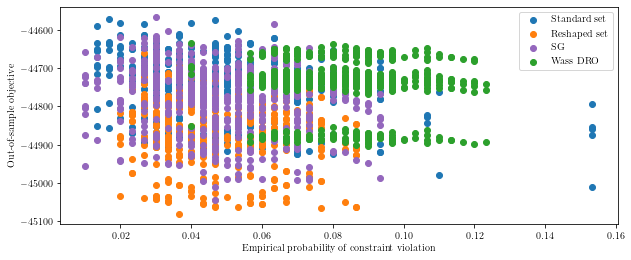

In [31]:
plt.figure(figsize = (10,4))
plt.scatter(standard_table[:,1], standard_table[:,0],label = "Standard set", color = "tab:blue")
plt.scatter(reshaped_table[:,1], reshaped_table[:,0],label = "Reshaped set", color = "tab:orange")
plt.scatter(sg_vals1[:,0], sg_vals1[:,1],label = "SG", color = "tab:purple")
plt.scatter(totalvios[:,1] ,totalobjs[:,1], color = "tab:green", label = " Wass DRO")
plt.xlabel("Empirical probability of constraint violation")
plt.ylabel("Out-of-sample objective")
plt.legend()
plt.show()

In [39]:
print("DRO = ", np.mean(totalvios, axis = 0)[2] , np.mean(totalobjs,axis = 0)[2], np.mean(totaltime, axis = 0)[2])
print("SG = ", np.mean(sg_vals1[:,0]), np.mean(sg_vals1[:,1]),np.mean(sg_vals1[:,2]))
print(np.mean(np.mean(standard_table[:,13].reshape(-1, 5), axis=1) >= 0.05))
print(np.mean(np.mean(reshaped_table[:,13].reshape(-1, 5), axis=1) >= 0.05))
print(np.mean(sg_vals1[:,0] >= 0.05))
print(np.mean(totalvios[:,2] >= 0.05))

DRO =  0.028860000107437372 -44654.18241644456 0.41673677725399977
SG =  0.04773333342373371 -44779.76815286121 0.08568870542000001
0.18888888888888888
0.1111111111111111
0.434
0.02


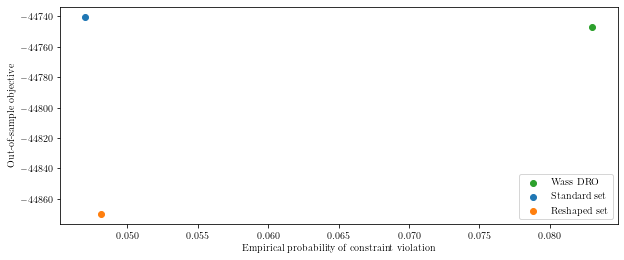

In [12]:
plt.figure(figsize = (10,4))
plt.scatter(np.mean(totalvios, axis = 0)[1] , np.mean(totalobjs,axis = 0)[1], color = "tab:green", label = " Wass DRO")
plt.scatter(np.mean(standard_table[:,1]), np.mean(standard_table[:,0]),label = "Standard set", color = "tab:blue")
plt.scatter(np.mean(reshaped_table[:,1]), np.mean(reshaped_table[:,0]),label = "Reshaped set", color = "tab:orange")
# plt.scatter(np.mean(sg_vals[:,0]), np.mean(sg_vals[:,1]), label = "SG", color = "tab:purple")
plt.xlabel("Empirical probability of constraint violation")
plt.ylabel("Out-of-sample objective")
plt.legend()
plt.show()

In [14]:
print(np.mean(standard_table[:,4] >= 0.05))
print(np.mean(reshaped_table[:,4] >= 0.05))
# print(np.mean(sg_vals[:,0] >= 0.05))
print(np.mean(totalvios[:,3] >= 0.05))

1.0
0.4111111111111111
0.0


In [7]:
def mro(train,test, K = 300, rho = 1, num_scenarios = num_scenarios, scenarios = scenarios):
    vios = np.zeros((num_scenarios))
    vios1 = np.zeros((num_scenarios))
    objs = np.zeros((num_scenarios))
    time = np.zeros((num_scenarios))
    for scene in range(num_scenarios):
        u = lropt.UncertainParameter(m,
                                        uncertainty_set = lropt.MRO(train = False, data = train, rho = rho, A = None, K = K))
        # formulate cvxpy variable
        L = cp.Variable()
        s = cp.Variable(n)
        y = cp.Variable(n)
        Y = cp.Variable((n,m))
        r = cp.Parameter(n)
        r.value = scenarios[scene][0]

        # formulate objective
        objective = cp.Minimize(L)

        # formulate constraints
        constraints = [-r@y - r@Y@u + (t+h)@s <= L]
        for i in range(n):
            constraints += [y[i]+Y[i]@u <= s[i]]
            constraints += [y[i]<= d[i]+ (Q[i] - Y[i])@u]
        constraints += [np.ones(n)@s == C]
        constraints += [s <=c, s >=0]

        # formulate Robust Problem
        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()
        obj = 0
        for i in test:
            obj += -r.value@y.value - r.value@Y.value@i + (t + h)@s.value
        objs[scene] = obj/300
        vios[scene] = eval(L.value,y.value,Y.value,s.value,r.value,test).item()
        vios1[scene] = eval(L.value,y.value,Y.value,s.value,r.value,train).item()
        time[scene] = newprob.solver_stats.solve_time
    return vios, vios1, objs, time

In [11]:
totalvios = np.zeros((num_scenarios*100,5))
totalvios_train = np.zeros((num_scenarios*100,5))
totalobjs = np.zeros((num_scenarios*100,5))
totaltime = np.zeros((num_scenarios*100,5))
epsrange = np.linspace(1.5, 2.5, 5)
for experiment in range(20):
    print(experiment)
    data = data_modes(600,m,[10,20,30],seed = experiment)
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=27)
    ind = 0
    for eps in epsrange:
        vios, vios1, objs, time = mro(train,test, K = 300, rho = eps)
        totalvios[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios
        print(experiment, vios, objs)
        totalvios_train[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios1
        totalobjs[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = objs 
        totaltime[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = time
        ind += 1
        np.save("totalvios2.npy", totalvios)
        np.save("totalvios_train2.npy", totalvios_train)
        np.save("totalobjs2.npy", totalobjs)
        np.save("totaltime2.npy", totaltime)

0
0 [0.12666667 0.12666667 0.12666667 0.12666667 0.12666667] [-44945.12560822 -44809.09329294 -44727.59871168 -44793.37480661
 -44786.14962241]


In [76]:
standard_table = pd.read_csv("standard_table_3.csv").iloc[:,1:].values
standard_table1 = pd.read_csv("standard_table_2.csv").iloc[:,1:].values
reshaped_table = pd.read_csv("reshaped_table_2.csv").iloc[:,1:].values
totalvios = np.load("totalvios2.npy")
totalvios_train = np.load("totalvios_train2.npy")
totalobjs = np.load("totalobjs2.npy")
totaltime = np.load("totaltime2.npy")
sg_vals1 = np.load("sg_vals1.npy")
Ar_saved = np.load("Ar_saved.npy")
br_saved = np.load("br_saved.npy")
As_saved = np.load("As_saved.npy")
bs_saved = np.load("bs_saved.npy")
sg_vals = np.load("sg_vals1.npy")

In [22]:
# sg_vals1 = np.zeros((num_scenarios*100,3))
for experiment in range(18,100):
    print(experiment)
    data = data_modes(600,m,[10,20,30],seed = experiment)
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=27)
    vios, objs, time = sg(train,test)
    sg_vals1[(experiment*num_scenarios):((experiment+1)*num_scenarios),0] = vios 
    sg_vals1[(experiment*num_scenarios):((experiment+1)*num_scenarios),1] = objs 
    sg_vals1[(experiment*num_scenarios):((experiment+1)*num_scenarios),2] = time
    np.save("sg_vals1.npy", sg_vals1)

18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [62]:
# Ar_saved = np.zeros((100,m,m))
# br_saved = np.zeros((100,m))
# As_saved = np.zeros((100,m,m))
# bs_saved = np.zeros((100,m))
# standard_table2 = np.zeros((1,6))
for experiment in range(42,75):
    print(experiment)
    data = data_modes(600,m,[10,20,30],seed = experiment)
    # formulate the ellipsoidal set
    u = lropt.UncertainParameter(m,
                                    uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                    rho=1., data =data, loss =loss))
    # formulate cvxpy variable
    L = cp.Variable()
    s = cp.Variable(n)
    y = cp.Variable(n)
    Y = cp.Variable((n,m))
    r = cp.Parameter(n)
    r.value = scenarios[scene][0]

    # formulate objective
    objective = cp.Minimize(L)
    constraints = [-r@y - r@Y@u + (t+h)@s <= L]
    for i in range(n):
        constraints += [y[i]+Y[i]@u <= s[i]]
        constraints += [y[i]<= d[i]+ (Q[i] - Y[i])@u]
    constraints += [np.ones(n)@s == C]
    constraints += [s <=c, s >=0]

    # formulate Robust Problem
    prob = lropt.RobustProblem(objective, constraints)
    target = -0.015
    # solve
    test_p = 0.5
    seed = 27
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=seed)
    init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
    init_bval = -init@np.mean(train, axis=0)

    A_fin = Ar_saved[experiment,:]
    b_fin = br_saved[experiment,:]

    result3A = As_saved[experiment,:] 
    result3b = bs_saved[experiment,:]

    result4 = prob.grid(epslst = np.linspace(0.9, 1.6, 80), init_A = result3A, init_b = result3b, seed = seed, init_alpha = 0., test_percentage =test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid = result4.df

    s_t = make_table(result3A, result3b, dfgrid,test,train, 0.007, eps = 0,cvar_train = 0, cvar_test = 0)
    standard_table2 = np.vstack((standard_table2, s_t))
    pd.DataFrame(standard_table2).to_csv("standard_table_3.csv")
# reshaped_table = reshaped_table[1:]
# standard_table = standard_table[1:]

42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


In [65]:
print("standard = ", np.mean(standard_table2[:,0]), np.mean(standard_table2[:,1]),np.mean(standard_table2[:,5]))

standard =  -44588.39638544667 0.01000913252212005 0.0030854012904109585


In [67]:
print(np.mean(standard_table2[:,1] >= 0.05))


0.0


In [82]:
table = np.zeros((4,6))
table[0,0] =  np.mean(np.mean(reshaped_table[:,6].reshape(-1, 5), axis=1))
table[1,0] =  np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1))
table[2,0] =  np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1) >= 0.05)
table[3,0] =  np.mean(np.mean(reshaped_table[:,11].reshape(-1, 5), axis=1))

table[0,1] =  np.mean(np.mean(reshaped_table[:,12].reshape(-1, 5), axis=1))
table[1,1] =  np.mean(np.mean(reshaped_table[:,13].reshape(-1, 5), axis=1))
table[2,1] =  np.mean(np.mean(reshaped_table[:,13].reshape(-1, 5), axis=1) >= 0.05)
table[3,1] =  np.mean(np.mean(reshaped_table[:,17].reshape(-1, 5), axis=1))

table[0,2] =  np.mean(np.mean(standard_table[:,0].reshape(-1, 5), axis=1))
table[1,2] =  np.mean(np.mean(standard_table[:,1].reshape(-1, 5), axis=1))
table[2,2] =  np.mean(np.mean(standard_table[:,1].reshape(-1, 5), axis=1) >= 0.05)
table[3,2] =  np.mean(np.mean(standard_table1[:,5].reshape(-1, 5), axis=1))

table[0,3] =  np.mean(np.mean(standard_table1[:,12].reshape(-1, 5), axis=1))
table[1,3] =  np.mean(np.mean(standard_table1[:,13].reshape(-1, 5), axis=1))
table[2,3] =  np.mean(np.mean(standard_table1[:,13].reshape(-1, 5), axis=1) >= 0.05)
table[3,3] =  np.mean(np.mean(standard_table1[:,17].reshape(-1, 5), axis=1))

table[0,4] =  np.mean(totalobjs,axis = 0)[2]
table[1,4] =  np.mean(totalvios, axis = 0)[2]
table[2,4] =  np.mean(np.mean(totalvios[:,2].reshape(-1, 5), axis=1) >= 0.05)
table[3,4] =  np.mean(totaltime, axis = 0)[2]

table[0,5] =  np.mean(sg_vals[:,1])
table[1,5] =  np.mean(sg_vals[:,0])
table[2,5] =  np.mean(sg_vals[:,0] >= 0.05)
table[3,5] =  np.mean(sg_vals[:,2])
pd.DataFrame(table).to_csv("table_vals2.csv")

In [85]:
np.mean(sg_vals[:,0] >= 0.05)

0.434